In [8]:
import numpy as np
import sys
import time
import os
import h5py
import os.path as op
import matplotlib.cm as cm
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
import array
%matplotlib inline
sys.path.append('..')
from zwatershed import *
from visualization.visualize_funcs import *
from edgelist_methods import *
path_to_folder = '/Users/chandansingh/drive/janelia/conv_net_scripts/'
path_to_data = path_to_folder + 'data/'
from multiprocessing import Pool

# -------------------------------- parameters ---------------------------------------
gt_seg = '/groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-1-h5/groundtruth_seg_thick.h5'
gt_aff = '/groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-1-h5/groundtruth_aff.h5'
# pred_file = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/sample_A_x1_y1_z1_xy1.h5'
# pred_file_2 = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/cutout_3k.h5'
pred_file = '/groups/turaga/home/turagas/turagalab/FROM_TIER2/singhc/train/output_200000/tstvol-1_2.h5'

out_folder = '/nobackup/turaga/singhc/par_zwshed/'
threshes = [2000]
cmap = matplotlib.colors.ListedColormap(np.vstack(((0, 0, 0), np.random.rand(255, 3))))
NUM_WORKERS = 16
MAX_LEN = 200

# -------------------------------- load data ---------------------------------------
f = h5py.File(pred_file, 'r')
preds = np.array(f['main']).astype('float32')
g = h5py.File(gt_seg,'r')
gt_seg = g['main']
print preds.shape

(3, 432, 432, 432)


# Divide Volumes, set up args

In [9]:
def dim_to_name(start):
    return str(start[0])+'_'+str(start[1])+'_'+str(start[2])+'_vl1/'
dims = np.array(preds.shape[1:])
print "dims",dims # x,y,z
num_vols = np.array([int(x/MAX_LEN)+1 for x in dims])
# num_vols[0] = 2 # delete this!
deltas = dims/num_vols
print "num_vols",num_vols
print "deltas",deltas
starts,ends = [],[]
for x in range(num_vols[0]):
    for y in range(num_vols[1]):
        for z in range(num_vols[2]):
            starts.append((x,y,z)*deltas)
            extra = 3*np.array([x==num_vols[0]-1,y==num_vols[1]-1,z==num_vols[2]-1],dtype='int')
            ends.append((x,y,z)*deltas + deltas + [1,1,1]+extra)
args = []
for i in range(len(starts)):
    s,e = starts[i],ends[i]
    pred_vol = preds[:,s[0]:e[0],s[1]:e[1],s[2]:e[2]]
    print i,s,e,pred_vol.shape
    args.append((pred_vol,threshes,out_folder+dim_to_name(s)))    

dims [432 432 432]
num_vols [3 3 3]
deltas [144 144 144]
0 [0 0 0] [145 145 145] (3, 145, 145, 145)
1 [  0   0 144] [145 145 289] (3, 145, 145, 145)
2 [  0   0 288] [145 145 436] (3, 145, 145, 144)
3 [  0 144   0] [145 289 145] (3, 145, 145, 145)
4 [  0 144 144] [145 289 289] (3, 145, 145, 145)
5 [  0 144 288] [145 289 436] (3, 145, 145, 144)
6 [  0 288   0] [145 436 145] (3, 145, 144, 145)
7 [  0 288 144] [145 436 289] (3, 145, 144, 145)
8 [  0 288 288] [145 436 436] (3, 145, 144, 144)
9 [144   0   0] [289 145 145] (3, 145, 145, 145)
10 [144   0 144] [289 145 289] (3, 145, 145, 145)
11 [144   0 288] [289 145 436] (3, 145, 145, 144)
12 [144 144   0] [289 289 145] (3, 145, 145, 145)
13 [144 144 144] [289 289 289] (3, 145, 145, 145)
14 [144 144 288] [289 289 436] (3, 145, 145, 144)
15 [144 288   0] [289 436 145] (3, 145, 144, 145)
16 [144 288 144] [289 436 289] (3, 145, 144, 145)
17 [144 288 288] [289 436 436] (3, 145, 144, 144)
18 [288   0   0] [436 145 145] (3, 144, 145, 145)
19 [288  

# Call Watershed

In [147]:
def zwshed_h5_par(arg):
    (pred_vol,threshes,seg_save_path) = arg
    zwatershed_h5(pred_vol, threshes,seg_save_path)
    print "finished",seg_save_path,"watershed"
p = Pool(NUM_WORKERS)
p.map(zwshed_h5_par, args)
# zwshed_h5_par(args[0])

finished /nobackup/turaga/singhc/par_zwshed/0_0_0_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/0_0_144_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/0_0_288_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/0_144_0_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/0_144_144_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/0_144_288_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/144_0_0_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/144_0_288_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/0_288_288_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/144_144_0_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/144_0_144_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/144_144_144_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/144_144_288_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/0_288_0_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

# Stitch

i,x,y,z 0 0 0 0
renums {}
counts {}
len counts 0
	merging numbers, 0 keys ... 
renums filtered {}
	before nsegs= 501 num0= 6078533
	after nsegs= 501 num0= 6078533


/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.


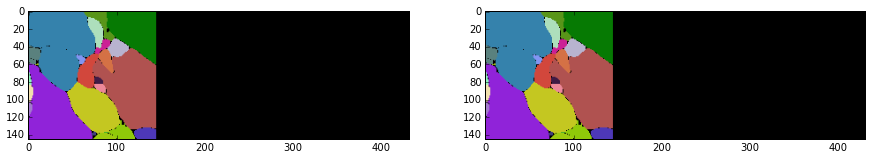

	renumbering all... 501 num0= 6078533
i,x,y,z 1 0 0 1
edge_mins [273 273 273 ..., 410 410 410]
edge_maxes [503 503 503 ..., 521 521 521]
len re_z 36
renums {384: 273, 513: 19, 514: 384, 515: 420, 516: 271, 517: 226, 519: 32, 520: 384, 521: 410, 522: 273, 523: 414, 524: 414, 525: 414, 526: 379, 273: 226, 512: 494, 408: 361, 410: 32, 414: 271, 423: 296, 296: 226, 361: 19, 495: 273, 496: 414, 497: 335, 498: 408, 499: 296, 500: 410, 501: 273, 503: 273, 505: 335, 506: 460, 507: 433, 508: 361, 509: 501, 511: 498}
counts {(521, 410): 3599, (500, 410): 1, (508, 414): 1, (522, 273): 3, (503, 273): 6876, (513, 410): 2, (508, 361): 638, (520, 384): 423, (519, 32): 470, (509, 501): 11, (508, 296): 423, (423, 414): 2, (508, 500): 10, (525, 414): 224, (523, 303): 259, (517, 226): 25, (273, 271): 2, (505, 497): 5, (508, 226): 1, (496, 414): 1, (503, 226): 1, (384, 273): 2, (503, 501): 1, (511, 408): 267, (496, 303): 1, (410, 32): 2, (423, 296): 15, (495, 273): 3, (499, 296): 6, (521, 32): 1, (296, 22

/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


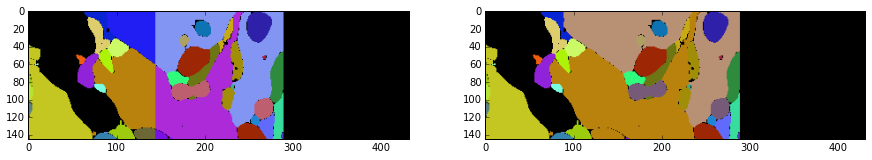

	renumbering all... 1116 num0= 3092297
i,x,y,z 2 0 0 2
edge_mins [226 226 226 ..., 271 271 271]
edge_maxes [1081 1081 1081 ..., 1091 1091 1091]
len re_z 93
renums {512: 494, 513: 19, 514: 384, 515: 420, 516: 271, 517: 226, 519: 32, 520: 384, 521: 410, 522: 273, 523: 414, 524: 414, 525: 414, 526: 379, 1056: 588, 1024: 588, 1063: 957, 1064: 957, 1065: 957, 1066: 958, 1068: 588, 1070: 957, 1071: 226, 1072: 957, 1074: 1008, 1075: 905, 1076: 1075, 1077: 1024, 1081: 226, 1082: 226, 1083: 226, 1084: 945, 1085: 1063, 1086: 1070, 1087: 957, 1088: 957, 1089: 957, 1090: 19, 1091: 271, 1092: 1064, 1093: 1079, 1094: 1039, 1096: 1016, 1097: 1065, 1098: 1065, 588: 271, 1101: 588, 1102: 1072, 1103: 974, 1104: 588, 1105: 973, 1106: 905, 1107: 951, 1108: 1066, 1109: 588, 1110: 1067, 1111: 19, 1112: 900, 1113: 1078, 1114: 854, 1117: 1062, 1118: 1069, 1062: 1056, 273: 226, 296: 226, 854: 588, 361: 19, 384: 273, 906: 588, 408: 361, 410: 32, 414: 271, 496: 414, 423: 296, 953: 588, 973: 226, 974: 954, 508: 3

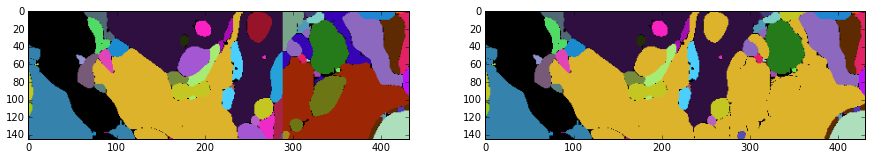

	renumbering all... 2046 num0= 137140
i,x,y,z 3 0 1 0
renums {}
counts {}
len counts 0
	merging numbers, 0 keys ... 
renums filtered {}
	before nsegs= 858 num0= 6095972
	after nsegs= 858 num0= 6095972


/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:41: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.


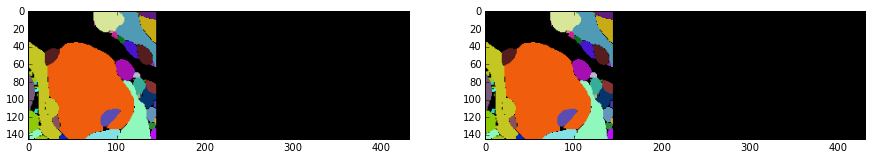

	renumbering all... 858 num0= 6095972
i,x,y,z 4 0 1 1
edge_mins [707 707 707 ..., 592 592 592]
edge_maxes [860 860 860 ..., 915 915 915]
len re_z 76
renums {896: 851, 897: 3, 898: 845, 899: 765, 900: 853, 901: 30, 902: 847, 903: 30, 904: 647, 905: 788, 908: 796, 909: 847, 910: 786, 911: 178, 912: 806, 913: 806, 786: 511, 915: 592, 916: 812, 918: 857, 793: 774, 920: 858, 772: 720, 774: 628, 178: 3, 777: 624, 628: 624, 827: 3, 832: 766, 865: 777, 840: 8, 841: 138, 844: 624, 845: 720, 848: 786, 895: 178, 851: 832, 852: 30, 889: 844, 856: 786, 592: 3, 858: 647, 860: 707, 861: 813, 862: 138, 863: 511, 864: 638, 720: 546, 866: 624, 867: 850, 868: 511, 869: 855, 870: 526, 871: 467, 872: 480, 873: 467, 874: 840, 875: 138, 877: 2, 878: 814, 880: 702, 881: 642, 882: 218, 883: 2, 884: 720, 885: 628, 886: 621, 887: 772, 888: 844, 788: 765, 890: 793, 891: 774, 892: 774, 893: 223, 894: 3, 511: 223}
counts {(896, 832): 149, (871, 845): 1, (866, 628): 2, (911, 178): 145, (892, 774): 22, (865, 844): 1,

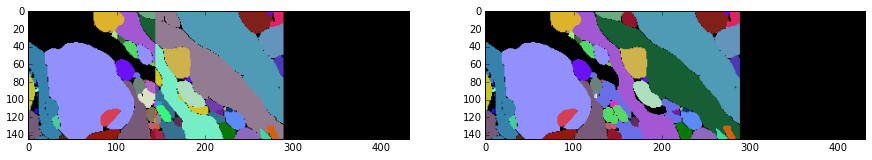

	renumbering all... 1792 num0= 3118035
i,x,y,z 5 0 1 2
edge_mins [   0    0 1654 ..., 1703    0    0]
edge_maxes [1717 1717 1721 ..., 1747 1747    0]
len re_z 114
renums {1536: 1265, 1539: 1493, 1544: 1315, 1714: 1539, 592: 3, 628: 624, 1662: 1524, 1713: 1493, 178: 3, 1715: 1703, 1718: 1493, 1719: 1698, 1720: 1315, 1721: 1654, 1722: 1523, 1723: 1539, 1724: 1265, 1725: 1493, 1726: 1493, 1727: 1707, 1733: 1681, 1734: 1315, 1735: 466, 1736: 1002, 1737: 1536, 1738: 1686, 1739: 1544, 1740: 1658, 1741: 634, 1742: 1002, 1743: 1711, 720: 546, 1745: 1524, 1746: 1506, 1747: 1703, 1748: 1644, 1749: 1662, 1750: 1662, 1744: 835, 1265: 466, 772: 720, 774: 628, 777: 624, 786: 511, 788: 765, 793: 774, 1315: 1265, 827: 3, 832: 766, 840: 8, 841: 138, 844: 624, 845: 720, 848: 786, 851: 832, 852: 30, 856: 786, 858: 647, 860: 707, 861: 813, 862: 138, 863: 511, 864: 638, 865: 777, 866: 624, 867: 850, 868: 511, 869: 855, 870: 526, 871: 467, 872: 480, 873: 467, 874: 840, 875: 138, 877: 2, 878: 814, 880: 702, 

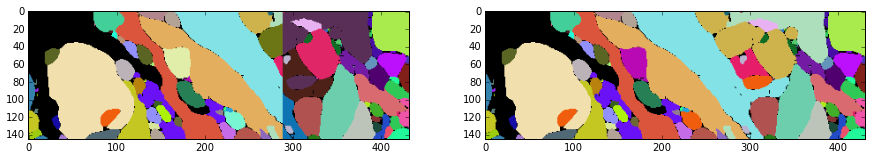

	renumbering all... 2766 num0= 165025


'\n    if x==0: # don\'t merge\n        seg_out[sx[0]:ex[0],:,:] = ybar[:,:,:]\n    else: # merge\n        re_x = calc_renums(edge_mins=seg_out[sx[0],:,:],edge_maxes=ybar[0,:,:],re=re_x)\n        seg_out[sx[0]:ex[0],:,:] = ybar[:,:,:]\nseg_out = merge_and_renum(re_x,seg_out,inc=False,p=False)\nprint "finished"\n# display_seg_xy(seg_out)\n'

In [55]:
# todo - have this support several threshes - for filename in os.listdir(arg[2]):
COUNT_THRESH = 0
filename = 'seg_2000.h5'
i = 0
seg_out = np.zeros(dims,dtype='uint64')
re_x = {}
for x in range(1): #num_vols[0]):
    i = x*num_vols[1]*num_vols[2]
    sx,ex = starts[i],ends[i]
    
    # start ybar --------------------------------------------------
    xdim = deltas[0]+1
    if x==num_vols[0]-1:
        xdim = dims[0]-deltas[0]*(num_vols[0]-1)
    ybar = np.zeros((xdim,dims[1],dims[2]),dtype='uint64')
    re_y = {}
    for y in range(0,2): #num_vols[1]):
        i = x*num_vols[1]*num_vols[2]+y*num_vols[2]
        sy,ey = starts[i], ends[i]
        
        # start zbar -----------------------------------------------
        ydim = deltas[1]+1
        if y==num_vols[1]-1:
            ydim = dims[1]-deltas[1]*(num_vols[1]-1)
        zbar = np.zeros((xdim,ydim,dims[2]),dtype='uint64')
        re_z = {} # maxes -> mins
        counts = {}
        for z in range(0,1): #num_vols[2]): 
            i = x*num_vols[1]*num_vols[2]+y*num_vols[2]+z
            arg,s,e = args[i],starts[i],ends[i]
            seg = np.array(h5py.File(arg[2]+filename,'r')['main'])
            seg[seg!=0]+=np.max(zbar)+1
            print "i,x,y,z",i,x,y,z
            if z==0: 
                zbar[:,:,s[2]:e[2]] = seg[:,:,:]
            else:         
                re_z = calc_renums(edge_mins=zbar[:,:,s[2]],edge_maxes=seg[:,:,0], re=re_z)
                print "len re_z",len(re_z)
                zbar[:,:,s[2]:e[2]] = seg[:,:,:]
            zbar = merge_and_renum(re_z,zbar,inc=False,p=True)
        zbar[zbar!=0] += np.max(ybar)+1
        # end zbar --------------------------------------------------
    '''
        counts = {}
        if y==0: # don't merge
            ybar[:,sy[1]:ey[1],:] = zbar[:,:,:]
        else: # merge
            re_y = calc_renums(edge_mins=ybar[:,s[1],:],edge_maxes=zbar[:,0,:], re=re_y)
            ybar[:,sy[1]:ey[1],:] = zbar[:,:,:]

        ybar = merge_and_renum(re_y,ybar,inc=False,p=True)
    ybar[ybar!=0] += np.max(seg_out)+1
    # end ybar -------------------------------------------------------
    '''
'''
    if x==0: # don't merge
        seg_out[sx[0]:ex[0],:,:] = ybar[:,:,:]
    else: # merge
        re_x = calc_renums(edge_mins=seg_out[sx[0],:,:],edge_maxes=ybar[0,:,:],re=re_x)
        seg_out[sx[0]:ex[0],:,:] = ybar[:,:,:]
seg_out = merge_and_renum(re_x,seg_out,inc=False,p=False)
print "finished"
# display_seg_xy(seg_out)
'''

In [40]:
# stitch methods
def calc_renums(edge_mins,edge_maxes, re):
    edge_mins = edge_mins.ravel()
    edge_maxes = edge_maxes.ravel()
    print "edge_mins",edge_mins
    print "edge_maxes",edge_maxes
    for j in range(len(edge_mins)):
        edge_min = edge_mins[j]
        edge_max = edge_maxes[j]
        if not edge_min==0 and not edge_max==0:
            if not edge_max==edge_min:
                if edge_max in re: # already in map
                    old_min = re[edge_max]
                    merge_max = max(old_min,edge_min)
                    merge_min = min(old_min,edge_min)
                    if not merge_max==merge_min:
                        re[merge_max] = merge_min
                        add_or_inc(merge_max,merge_min,counts)
            re[edge_max] = edge_min
            add_or_inc(edge_max,edge_min,counts)
    return re
    
def prune_and_renum(seg,sizeThreshold=1):
    segId = np.unique(seg)
    renum = np.zeros(segId.max()+1,dtype='uint64')
    renum[segId] = np.arange(1,len(segId)+1)
    renum[0] = 0
    seg = renum[seg]
    return seg

def add_or_inc(key_max,key_min,d):
    key = (key_max,key_min)
    if not key in d:
        d[key] = 1
    else:
        d[key] +=1
    
def merge_and_renum(renums,zbar,inc=True,p=False):
    # merge numbers
    print "renums",renums
    print "counts",counts
    print "len counts",len(counts)
    sum_counts = 0
    for key in counts:
        sum_counts += counts[key]
#     print "ave counts",float(sum_counts) / len(counts)
#     print "counts",counts
#     print "renums",renums
    renums2 = {}
    print "\tmerging numbers,",len(renums.keys()),"keys ... "            
    for key in renums:
        val = renums[key]
        if counts[(key,val)] > COUNT_THRESH:
            while val in renums:
                val = renums[val]
            renums2[key] = val
    print "renums filtered",renums2
            
    print "\tbefore nsegs=",len(np.unique(zbar)),"num0=",np.sum(zbar==0)
    if p:
        fig = plt.figure(figsize=(15, 7))
        plt.subplot(1,2,1)
        plt.imshow(zbar[0, :, :], cmap=cmap)
    
    mp = np.arange(0,np.max(zbar)+1,dtype='uint64')
    mp[renums2.keys()] = renums2.values()
    zbar = mp[zbar]
    print "\tafter nsegs=",len(np.unique(zbar)),"num0=",np.sum(zbar==0)
    if p:
        plt.subplot(1,2,2)
        plt.imshow(zbar[0, :, :], cmap=cmap)
    plt.show()
    
    # renumber all
    print "\trenumbering all...",np.max(zbar),"num0=",np.sum(zbar==0)
    zbar = prune_and_renum(zbar,2)
#     if p:
#         plt.imshow(zbar[1, :, :], cmap=cmap)
#     plt.show()
#     print "\tend all...",np.max(zbar),"num0=",np.sum(zbar==0)
    if inc:
        zbar[zbar!=0] += np.max(zbar)+1
    return zbar

# Visualize

In [138]:
def display_affs(raw):
    plt.imshow(np.transpose(raw[:, :, :, 1],(2,1,0)))
    plt.show()
def display_seg_yz(raw,depth=1):
    fig = plt.figure(figsize=(15, 7))
    plt.imshow(raw[depth, :, :], cmap=cmap)
    plt.show()
def display_seg_xy(raw,depth=1):
    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0.2, bottom=0.25)
    ax1.imshow(raw[:, :, depth], cmap=cmap)
    plt.show()

(3, 125, 300, 300)
preds0
0.999997
0.000641769
0.734931
1.0
0.058145
0.860175
1.0
0.124801
0.86506
(125, 300, 300, 3)
(125, 313, 314)


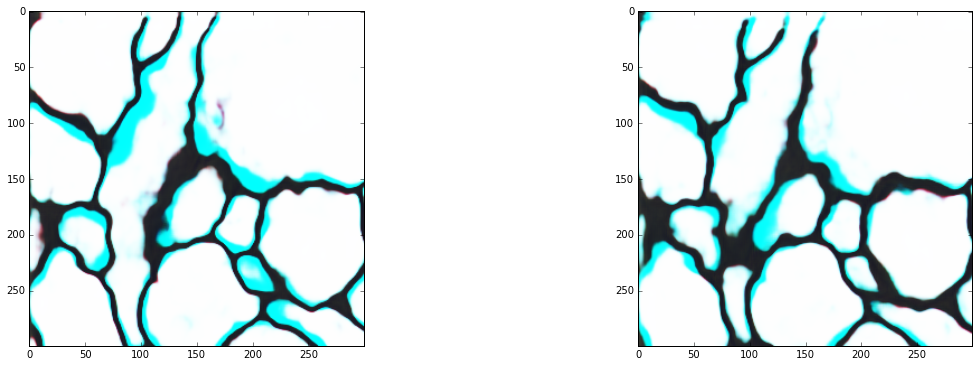

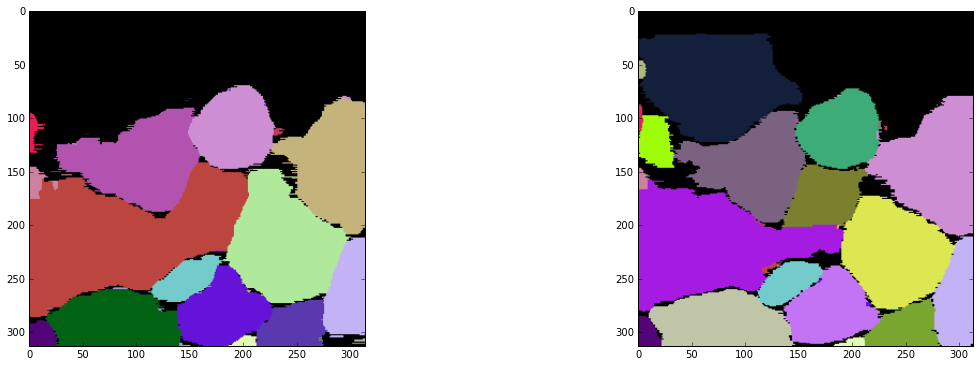

In [27]:
# display_affs(preds,preds,preds)
p_small = preds[:300,:300,:300,:300]
print p_small.shape
preds0 = p_small[0,:,:,:]
print "preds0"
print np.max(preds0)
print np.min(preds0)
print np.average(preds0)
preds1 = p_small[1,:,:,:]
print np.max(preds1)
print np.min(preds1)
print np.average(preds1)
preds2 = p_small[2,:,:,:]
print np.max(preds2)
print np.min(preds2)
print np.average(preds2)
raw = np.transpose(p_small,(1,2,3,0))
print raw.shape
# seg = zwatershed(p_small,[2000])[0]
print seg.shape
fig = plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
plt.imshow(raw[50, :, :, :])
plt.subplot(1,2,2)
plt.imshow(raw[51, :, :, :])
plt.show()
fig = plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
plt.imshow(seg[50, :, :],cmap=cmap)
plt.subplot(1,2,2)
plt.imshow(seg[51, :, :],cmap=cmap)
plt.show()